# Run STitch3D on the breast cancer dataset

In this tutorial, we show STitch3D's analysis of the human dorsolateral prefrontal cortex (DLPFC) dataset. 

The spatial transcriptomics data are publicly available at https://zenodo.org/record/4751624. 
The breast cancer dataset profiled by 10x Genomics Chromium platform is available at https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE176078.

## Import packages

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.io import mmread
import os
import sys

import STitch3D

import warnings
warnings.filterwarnings("ignore")

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## Preprocessing

### Load datasets

Load single-cell reference dataset:

In [2]:
# reference data
ref_count = mmread("./data/BrCa_Atlas_Count_out/matrix.mtx")
adata_ref_raw = ad.AnnData(X=ref_count.tocsr().T)

barcodes = pd.read_csv("./data/BrCa_Atlas_Count_out/barcodes.tsv",
                       header=None, index_col=0)
features = pd.read_csv("./data/BrCa_Atlas_Count_out/features.tsv",
                       header=None, index_col=0, sep='\t')

meta = pd.read_csv("./data/Whole_BrCa_miniatlas/Whole_miniatlas_meta.csv", 
                   skiprows=[1])
meta.index = meta.NAME
meta.index.name = None

adata_ref_raw.obs.index = barcodes.index
adata_ref_raw.obs["Patient"] = meta.loc[barcodes.index]["Patient"]
adata_ref_raw.obs["celltype_major"] = meta.loc[barcodes.index]["celltype_major"]
adata_ref_raw.obs["celltype_minor"] = meta.loc[barcodes.index]["celltype_minor"]
adata_ref_raw.obs["celltype_subset"] = meta.loc[barcodes.index]["celltype_subset"]
adata_ref_raw.obs["subtype"] = meta.loc[barcodes.index]["subtype"]
adata_ref_raw.obs.index.name = None
adata_ref_raw.var.index = features.index
adata_ref_raw.var.index.name = None

adata_ref_raw.write("./data/adata_ref_raw.h5ad")

adata_ref_raw = ad.read_h5ad("./data/adata_ref_raw.h5ad")
adata_ref = adata_ref_raw[adata_ref_raw.obs["subtype"].values.astype(str)=="HER2+", :]

# Delete cycling cells and cell types with less than 50 cells
adata_ref = adata_ref[adata_ref.obs["celltype_minor"] != "Cycling T-cells"]
adata_ref = adata_ref[adata_ref.obs["celltype_minor"] != "Cycling_Myeloid"]
adata_ref = adata_ref[adata_ref.obs["celltype_minor"] != "Cycling PVL"]
adata_ref = adata_ref[adata_ref.obs["celltype_minor"] != "Cancer Cycling"]
adata_ref = adata_ref[adata_ref.obs["celltype_minor"] != "B cells Naive"]
adata_ref = adata_ref[adata_ref.obs["celltype_minor"] != "Endothelial Lymphatic LYVE1"]
adata_ref = adata_ref[adata_ref.obs["celltype_minor"] != "Cancer LumB SC"]
adata_ref = adata_ref[adata_ref.obs["celltype_minor"] != "Cancer LumA SC"]
adata_ref = adata_ref[adata_ref.obs["celltype_minor"] != "Cancer Basal SC"]

Load spatial transcriptomics datasets:

In [3]:
# spatial data
patho_anno = pd.read_csv("./data/HER2-positive/meta/E1_labeled_coordinates.tsv", index_col=0, sep='\t')

adata_st_list_raw = []

for i in range(1, 4):
    
    st_count = pd.read_csv("./data/HER2-positive/count-matrices/E%d.tsv.gz" % i, index_col=0, sep='\t')
    st_meta = pd.read_csv("./data/HER2-positive/spot-selections/E%d_selection.tsv.gz" % i, sep='\t')
    st_meta.index = [str(st_meta['x'][i]) + 'x' + str(st_meta['y'][i]) for i in range(st_meta.shape[0])]
    st_meta = st_meta.loc[st_count.index]

    
    adata_st_i = ad.AnnData(X=st_count.values)
    adata_st_i.obs.index = st_count.index
    adata_st_i.obs = st_meta
    adata_st_i.var.index = st_count.columns
    
    img = imread('./data/HER2-positive/images/HE/E%d.jpg' % i)
    library_id = 'st'
    adata_st_i.uns["spatial"] = dict()
    adata_st_i.uns["spatial"][library_id] = dict()
    adata_st_i.uns["spatial"][library_id]['images'] = dict()
    adata_st_i.uns["spatial"][library_id]['images']['hires'] = img
    adata_st_i.uns["spatial"][library_id]['images']['lowres'] = img
    adata_st_i.uns["spatial"][library_id]['scalefactors'] = {'spot_diameter_fullres': 100,
                                                             'tissue_hires_scalef': 1.0,
                                                             'fiducial_diameter_fullres': 100,
                                                             'tissue_lowres_scalef': 1.0}
    
    adata_st_i.obsm['spatial'] = np.concatenate((np.array(st_meta["pixel_x"]).reshape(-1,1),
                                                 np.array(st_meta["pixel_y"]).reshape(-1,1)), axis=1)
    
    adata_st_i.obsm['loc_use'] = np.concatenate((np.array(st_meta["x"]).reshape(-1,1),
                                                 np.array(st_meta["y"]).reshape(-1,1)), axis=1)
    adata_st_i.obs['array_row'] = adata_st_i.obs["x"].values
    adata_st_i.obs['array_col'] = adata_st_i.obs["y"].values
    adata_st_i.obs['st_sample'] = str(i)
    
    if i == 1:
        adata_st_i.obs['annotation'] = None
        for idx in adata_st_i.obs.index:
            adata_st_i.obs['annotation'].loc[idx] = patho_anno[(patho_anno["x"] == adata_st_i[idx].obs["new_x"].values[0]) & 
                                                               (patho_anno["y"] == adata_st_i[idx].obs["new_y"].values[0])]['label'].values[0]
    else:
        adata_st_i.obs['annotation'] = "Unknown"
    
    adata_st_list_raw.append(adata_st_i)

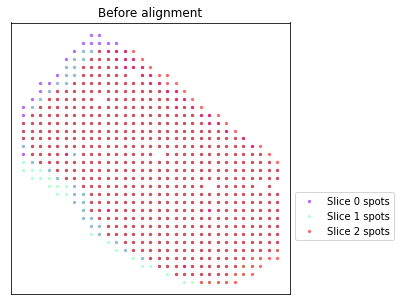

Using the Iterative Closest Point algorithm for alignemnt.
Detecting edges...
Aligning edges...


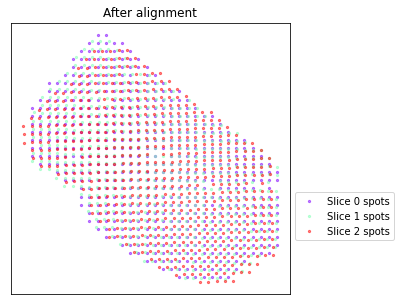

In [4]:
adata_st_list = STitch3D.utils.align_spots(adata_st_list_raw,
                                           data_type="ST",
                                           coor_key="loc_use",
                                           plot=True)

### Selecting highly variable genes and building 3D spatial graph

In [5]:
adata_st, adata_basis = STitch3D.utils.preprocess(adata_st_list,
                                                  adata_ref,
                                                  celltype_ref_col="celltype_minor",
                                                  sample_col="Patient",
                                                  coor_key="loc_use",
                                                  slice_dist_micron=[16] * 2,
                                                  c2c_dist=200.,
                                                  n_hvg_group=500)

Finding highly variable genes...
4491 highly variable genes selected.
Calculate basis for deconvolution...
5 batches are used for computing the basis vector of cell type <B cells Memory>.
5 batches are used for computing the basis vector of cell type <CAFs MSC iCAF-like>.
5 batches are used for computing the basis vector of cell type <CAFs myCAF-like>.
3 batches are used for computing the basis vector of cell type <Cancer Her2 SC>.
5 batches are used for computing the basis vector of cell type <DCs>.
5 batches are used for computing the basis vector of cell type <Endothelial ACKR1>.
5 batches are used for computing the basis vector of cell type <Endothelial CXCL12>.
4 batches are used for computing the basis vector of cell type <Endothelial RGS5>.
2 batches are used for computing the basis vector of cell type <Luminal Progenitors>.
5 batches are used for computing the basis vector of cell type <Macrophage>.
2 batches are used for computing the basis vector of cell type <Mature Luminal>

## Running STitch3D model

In [6]:
model = STitch3D.model.Model(adata_st, adata_basis, hidden_dims=[512, 128], training_steps=20000, coef_fe=0.1)

In [7]:
model.train()

  0%|          | 7/20000 [00:00<15:43, 21.19it/s]  

Step: 0, Loss: 1502.2242, d_loss: 1496.8077, f_loss: 54.1647


 10%|█         | 2008/20000 [00:49<07:18, 41.01it/s]

Step: 2000, Loss: -1644.4768, d_loss: -1647.5516, f_loss: 30.7486


 20%|██        | 4008/20000 [01:37<06:30, 40.96it/s]

Step: 4000, Loss: -1690.4707, d_loss: -1693.4446, f_loss: 29.7394


 30%|███       | 6008/20000 [02:26<05:41, 40.96it/s]

Step: 6000, Loss: -1697.1182, d_loss: -1699.9968, f_loss: 28.7861


 40%|████      | 8008/20000 [03:15<04:54, 40.73it/s]

Step: 8000, Loss: -1697.2074, d_loss: -1700.1105, f_loss: 29.0302


 50%|█████     | 10008/20000 [04:04<04:03, 40.96it/s]

Step: 10000, Loss: -1701.4795, d_loss: -1704.2294, f_loss: 27.4990


 60%|██████    | 12008/20000 [04:53<03:15, 40.91it/s]

Step: 12000, Loss: -1702.1022, d_loss: -1704.8064, f_loss: 27.0417


 70%|███████   | 14008/20000 [05:41<02:26, 40.94it/s]

Step: 14000, Loss: -1701.2375, d_loss: -1704.1332, f_loss: 28.9559


 80%|████████  | 16008/20000 [06:30<01:37, 40.94it/s]

Step: 16000, Loss: -1703.4333, d_loss: -1706.0797, f_loss: 26.4632


 90%|█████████ | 18008/20000 [07:19<00:48, 41.03it/s]

Step: 18000, Loss: -1703.8922, d_loss: -1706.5061, f_loss: 26.1386


100%|██████████| 20000/20000 [08:07<00:00, 40.99it/s]


## Saving STitch3D results

In [8]:
output_path = "./results_breast_cancer"

result = model.eval(adata_st_list, save=True, output_path=output_path)

## Visualizing results in 2D

Slice 1


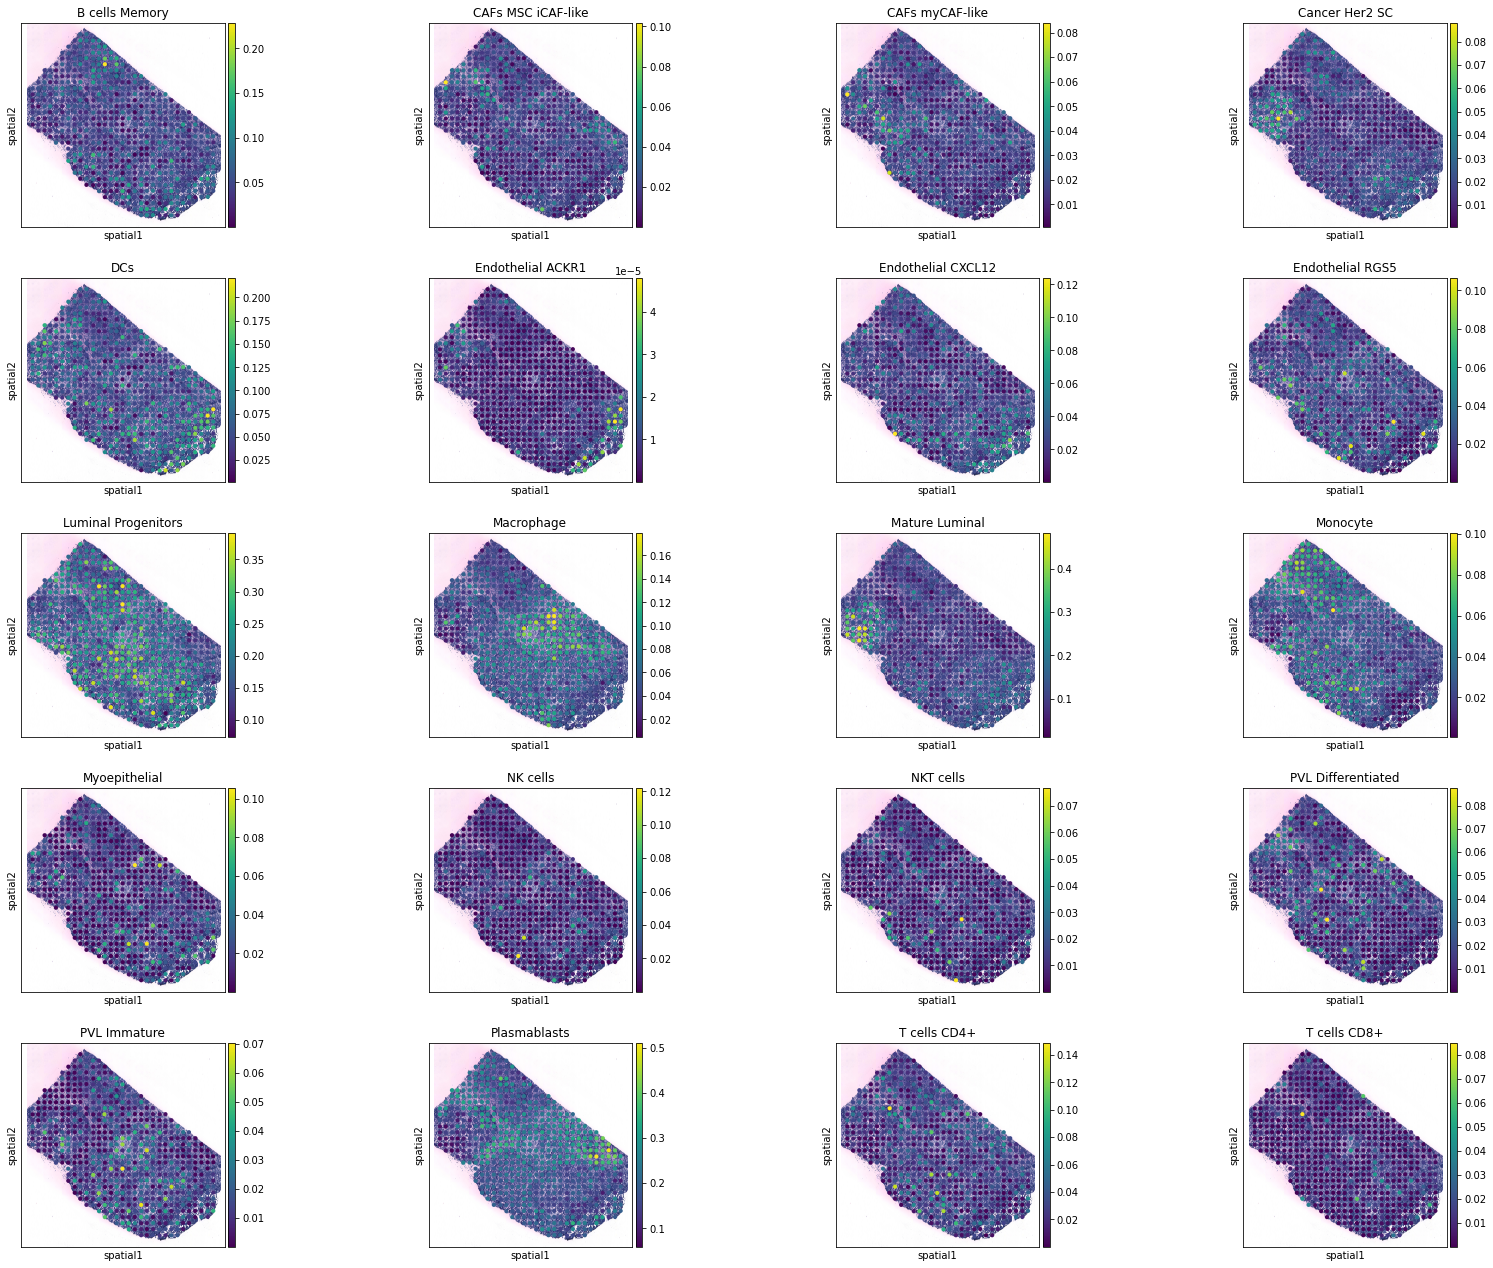

Slice 2


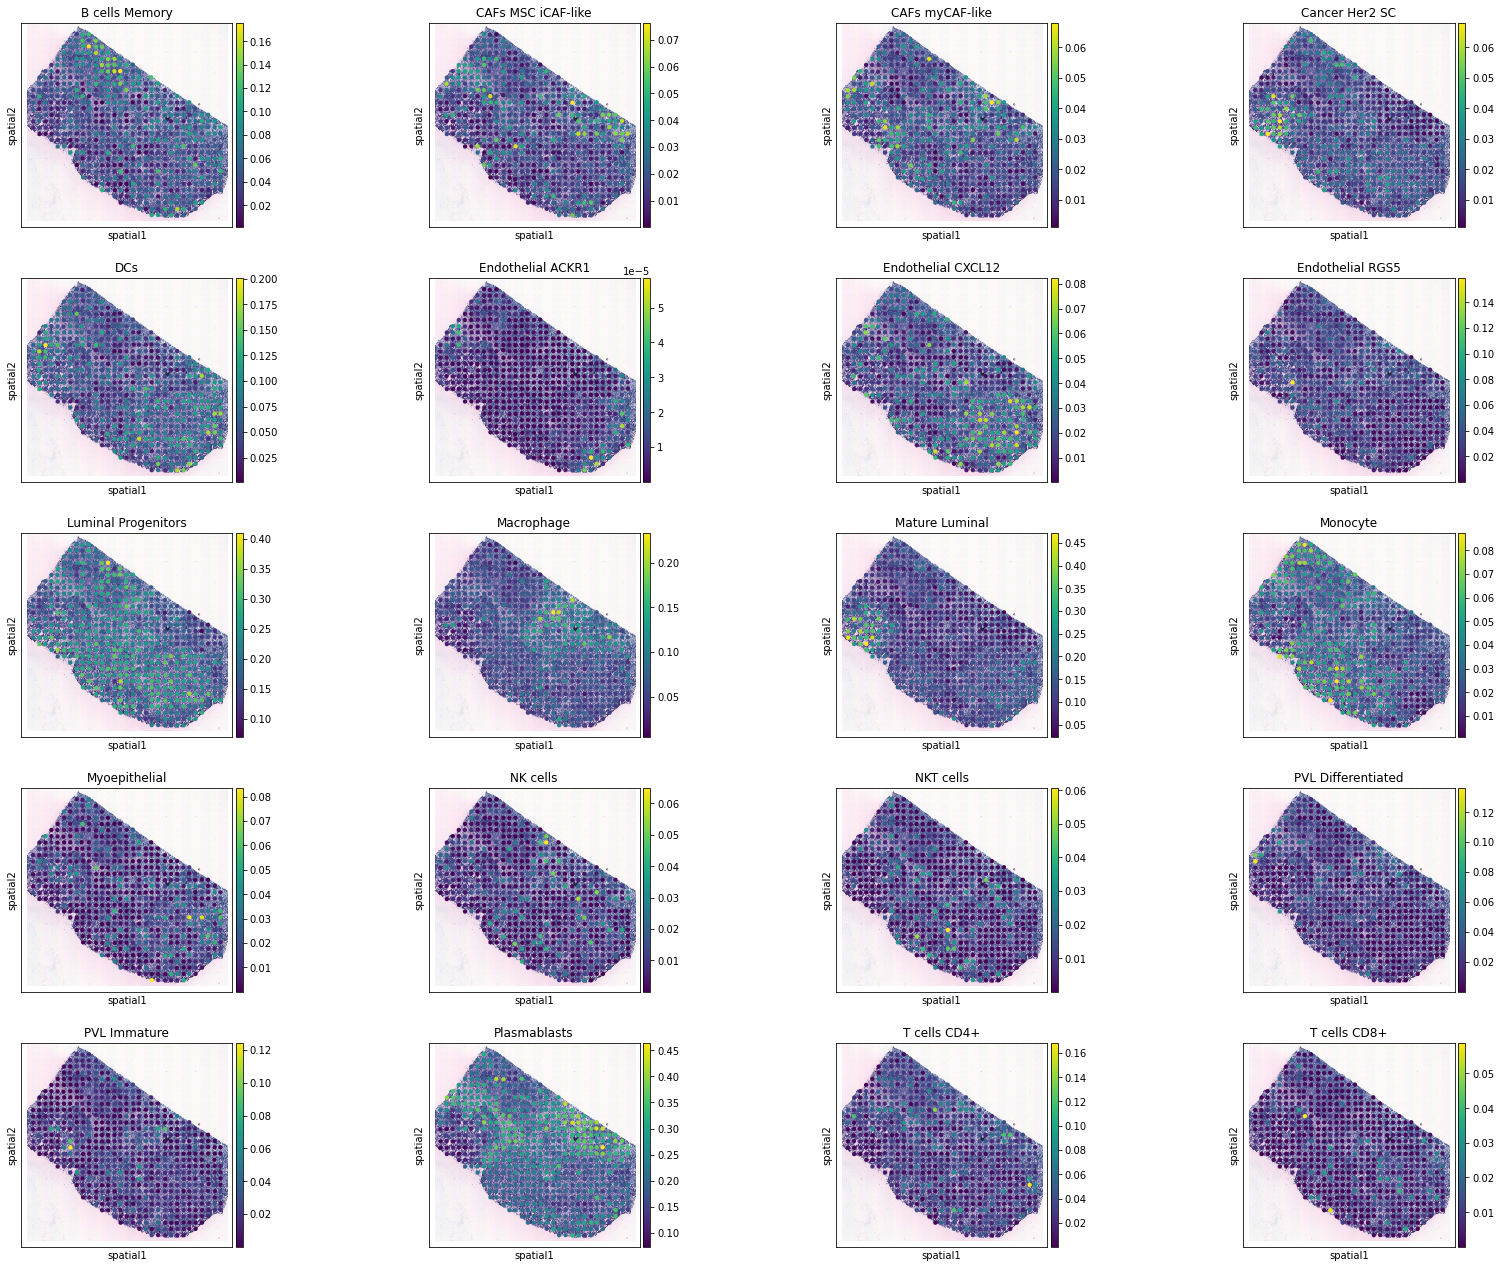

Slice 3


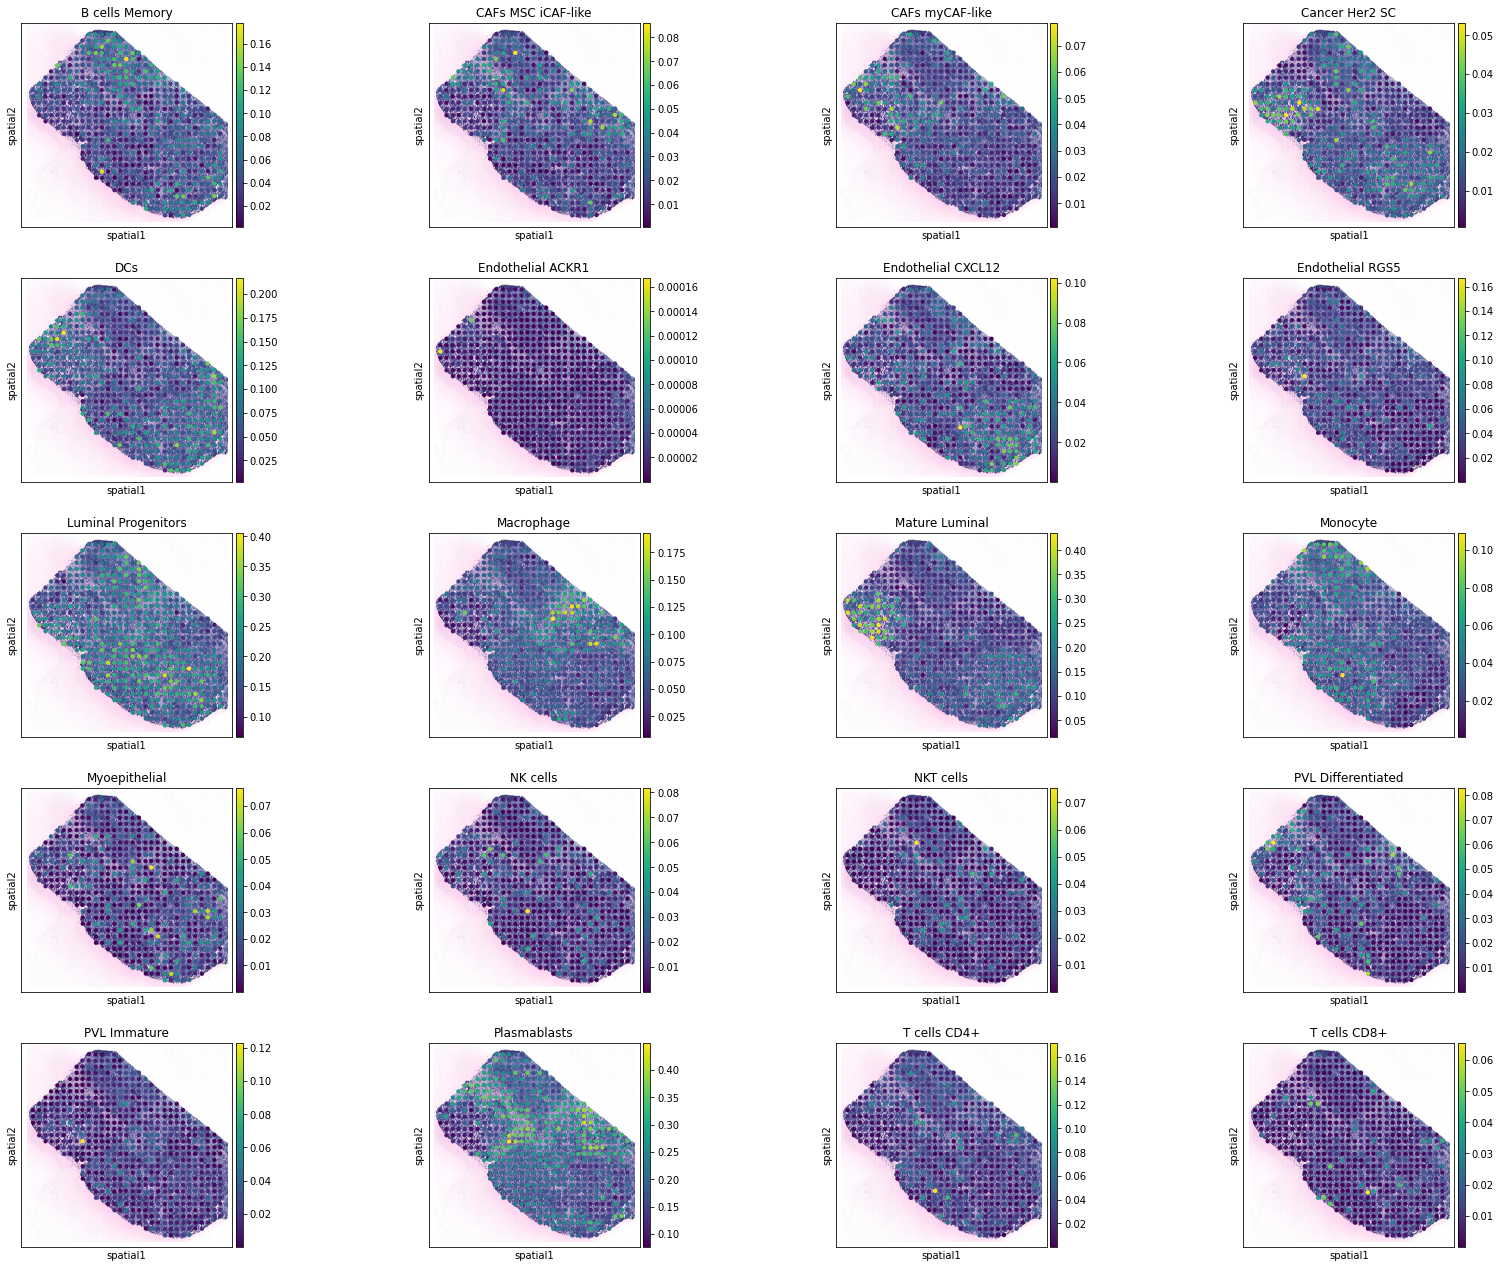

In [9]:
for i, adata_st_i in enumerate(result):
    print("Slice %d" % (i+1))
    sc.pl.spatial(adata_st_i, img_key="hires", color=model.celltypes, spot_size=200.)